<a href="https://colab.research.google.com/github/bhavya31-bit/Public-Transport-Delay-Prediction/blob/main/Public_Transport_Dealy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving ttc_data.csv to ttc_data (1).csv
Dataset Loaded: ttc_data (1).csv
Shape: (27351, 6)


,Date,Route,Time,Day,Min Delay,Min Gap
0,01-Jan-22,320,02:00,Saturday,0,0
1,01-Jan-22,325,02:00,Saturday,131,161
2,01-Jan-22,320,02:00,Saturday,17,20
3,01-Jan-22,320,02:07,Saturday,4,11
4,01-Jan-22,320,02:13,Saturday,4,8


/tmp/ipython-input-2270031525.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Hour"] = pd.to_datetime(df["Time"], errors="coerce").dt.hour


Average Delay: 20.3 minutes

MODEL PERFORMANCE
MAE (minutes): 2.04
R² Score: 0.93


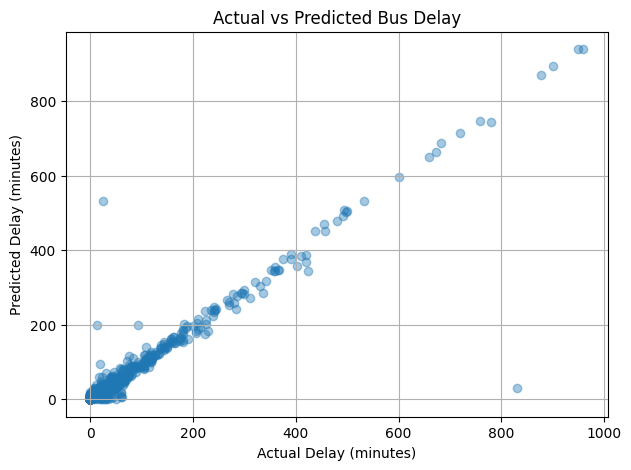

In [ ]:
#  DATA LOADING

from google.colab import files
uploaded = files.upload()

import zipfile
import pandas as pd
import matplotlib.pyplot as plt

file_name = list(uploaded.keys())[0]

if file_name.endswith(".zip"):
    with zipfile.ZipFile(file_name, 'r') as z:
        z.extractall()
        csv_file = [f for f in z.namelist() if f.endswith(".csv")][0]
else:
    csv_file = file_name

df = pd.read_csv(csv_file)

print("Dataset Loaded:", csv_file)
print("Shape:", df.shape)
display(df.head())

# FEATURE ENGINEERING

df["Hour"] = pd.to_datetime(df["Time"], errors="coerce").dt.hour

df = df.dropna(subset=["Hour", "Min Delay", "Min Gap"])

df["Min Delay"] = df["Min Delay"].clip(lower=0)
df["Min Gap"] = df["Min Gap"].clip(lower=0)

df = df[["Route", "Day", "Hour", "Min Gap", "Min Delay"]]

df["Route"] = df["Route"].astype(str)
df["Day"] = df["Day"].fillna("Unknown")

# ENCODING (SAFE)

from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in ["Route", "Day"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = df.drop("Min Delay", axis=1)
y = df["Min Delay"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Average Delay:", round(y.mean(), 2), "minutes")

#  MODEL TRAINING

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# EVALUATION

from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

print("\nMODEL PERFORMANCE")
print("MAE (minutes):", round(mean_absolute_error(y_test, y_pred), 2))
print("R² Score:", round(r2_score(y_test, y_pred), 2))

# ACTUAL vs PREDICTED GRAPH

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Actual vs Predicted Bus Delay")
plt.grid(True)
plt.show()



In [ ]:
!pip install gradio -q

import gradio as gr
import numpy as np
import pandas as pd

# AUTO MIN GAP ESTIMATION TABLE
min_gap_table = (
    df.groupby(["Route", "Day", "Hour"])["Min Gap"]
      .mean()
      .reset_index()
)

GLOBAL_MIN_GAP = df["Min Gap"].mean()

# SORT ROUTES NUMERICALLY
def route_sort_key(x):
    try:
        return int(x)
    except:
        return float('inf')

routes_sorted = sorted(
    encoders["Route"].classes_.tolist(),
    key=route_sort_key
)

# SORT DAYS LOGICALLY (MON → SUN)
preferred_day_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

available_days = encoders["Day"].classes_.tolist()

days_sorted = sorted(
    available_days,
    key=lambda x: preferred_day_order.index(x)
    if x in preferred_day_order else len(preferred_day_order)
)

# PREDICTION FUNCTION
def predict_delay(route, day, hour):

    hour = int(hour)

    route_enc = encoders["Route"].transform([route])[0]
    day_enc = encoders["Day"].transform([day])[0]

    row = min_gap_table[
        (min_gap_table["Route"] == route_enc) &
        (min_gap_table["Day"] == day_enc) &
        (min_gap_table["Hour"] == hour)
    ]

    if not row.empty:
        min_gap_est = row["Min Gap"].values[0]
    else:
        min_gap_est = GLOBAL_MIN_GAP

    input_data = np.array([[route_enc, day_enc, hour, min_gap_est]])
    prediction = model.predict(input_data)[0]

    return (
        f"Predicted Delay: {round(prediction, 2)} minutes\n"
        f"(Estimated Min Gap: {round(min_gap_est, 2)} minutes)"
    )

#  GRADIO INTERFACE
interface = gr.Interface(
    fn=predict_delay,
    inputs=[
        gr.Dropdown(routes_sorted, label="Route", value=routes_sorted[0]),
        gr.Dropdown(days_sorted, label="Day", value=days_sorted[0]),
        gr.Slider(0, 23, step=1, label="Hour")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="🚌 Public Transport Delay Prediction System",
    description=(
        "Predicts bus delay using route and time. "
        "Service gap (Min Gap) is automatically estimated "
        "from historical data."
    )
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a7329f12ce49550f5b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
